# Mushroom Classification Final Notebook

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Models
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
# Pipeline
from sklearn.pipeline import Pipeline

from sklearn import set_config
set_config(display= 'diagram')

from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, OrdinalEncoder, MaxAbsScaler
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, roc_curve, plot_roc_curve, classification_report

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [7]:
df = pd.read_csv('data/secondary_data.csv', delimiter=';')
df

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61064,p,1.18,s,s,y,f,f,f,f,3.93,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
61065,p,1.27,f,s,y,f,f,f,f,3.18,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
61066,p,1.27,s,s,y,f,f,f,f,3.86,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u
61067,p,1.24,f,s,y,f,f,f,f,3.56,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u


Display all columns for inspection, according to documentation, class is the edibility of the mushroom:

In [8]:
df.columns

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

Visualize numeric predictors effect on class:

''

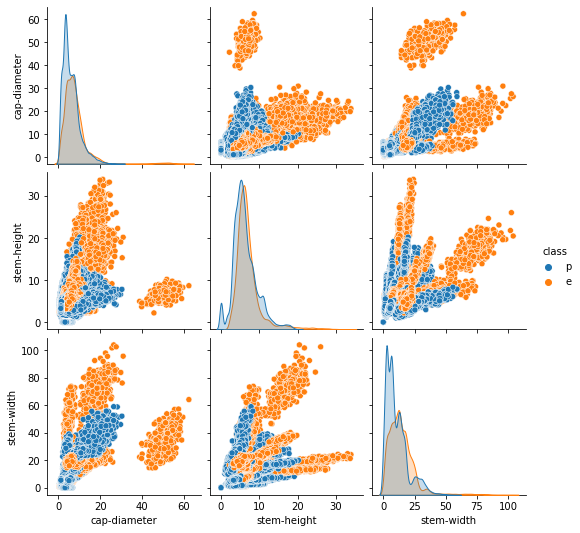

In [9]:
sns.pairplot(df, hue='class')
;

Establish X and y variables and split data into train and test groups early to prevent data leakage:

In [5]:
X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=13, stratify=y)

Important note:

Dropping columns with high numbers of NA values may seem like the wise thing to do but we do not here. This is for three reasons, the first is that going forward with this model we may encounter a training set that our machine learning model determines is important for classifying edibility. For instance, the final decision tree model does not take into account the spore print color, but when identifying in my leisure time I personally use this metric every time I find a new mushroom. Although this aspect may have some of my own personal bias, leaving them does not hurt the model, leading into the next point. Secondly, by keeping some of these columns we actually improve the model, even using columns with high 

Thirdly, I'm finding that if you dont impute values for these NAs, sklearn ignores the columns in its modelling anyway (see feature importance after model ____.

## Baseline Model

For the rest of the project, we rely heavily on sklearn's Pipeline to create and assess our models. The first two blocks of code give us the steps that are then run in parallel by combining them under the ColumnTransformer. We then establish our baseline model pipeline and fit it to the training data, and determine the accuracy of the model on training and test data sets.

In [ ]:
numeric_pipeline = Pipeline([('numimputer', SimpleImputer(strategy = 'mean')), ('numnorm', StandardScaler())])

nominal_pipeline = Pipeline([
    ('onehotenc', OneHotEncoder(sparse = False, drop = 'first'))])
    
ct = ColumnTransformer([("nominalpipe", nominal_pipeline, cat_cols),
                        ("numpipe", numeric_pipeline, num_cols)])
                        #,('ordpipe', ordinal_pipeline, ord_cols)])

model_pipe1 = Pipeline([('preprocess', ct),('model', LogisticRegression(max_iter=400))])

model_pipe1.fit(X_train,y_train)
print('train score: {}'.format(model_pipe1.score(X_train,y_train)))
print('test score: {}'.format(model_pipe1.score(X_test,y_test)))
model_pipe1

Above is a neat visualization of the pipeline workflow. Below is the baseline confusion matrix, ROC curve, and classification report.

In [ ]:
plot_confusion_matrix(model_pipe1, X_test, y_test)

In [ ]:
plot_roc_curve(model_pipe1, X_test, y_test)

In [ ]:
y_pred1 = model_pipe1.predict(X_test)
print(classification_report(y_test, y_pred1))

## Decision Tree

In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=50,random_state=13)

model_tree = Pipeline([('preprocess', ct), ('d_tree', tree_clf)])
model_tree.fit(X_train, y_train)

print('Training:', model_tree.score(X_train, y_train))
print('Testing:', model_tree.score(X_test, y_test))

This model is a huge improvement over the baseline.

To improve on this, we will try a Random Forest model. The Random Forest model 

Note: going forward I am going to include a timer on the models to give an idea of how long these computations take, which I find fascinating.

## Random Forest

In [ ]:
# start timer
starttime = time.time()
print('Start timer')

rf_param_grid = {'preprocess__numpipe__numimputer__strategy': ['mean'],
    'randfor__n_estimators': [10, 30, 100],
    'randfor__criterion': ['gini', 'entropy'],
    'randfor__max_depth': [None, 2, 6, 10],
    'randfor__min_samples_split': [5, 10],
    'randfor__min_samples_leaf': [3, 6]
}

rf = RandomForestClassifier()

model_rf = Pipeline([('preprocess', ct), ('randfor', rf)])

gs_pipe_rf = GridSearchCV(estimator=model_rf, 
                       param_grid=rf_param_grid)

gs_pipe_rf.fit(X_train, y_train)

print('train score: {}'.format(gs_pipe_rf.score(X_train,y_train)))
print('test score: {}'.format(gs_pipe_rf.score(X_test,y_test)))

# end timer
endtime = time.time()

# display time elapsed
converttime = time.strftime("%H:%M:%S", time.gmtime(endtime - starttime))
print('Time elapsed: {}'.format(converttime))

In [ ]:
f, ax = plt.subplots(figsize=(250, 250))
plot_tree(gs_pipe_rf, ax=ax);

## KNN

In [ ]:
# start timer
starttime = time.time()
print('Start timer')

# hyperparameter tuning
pipe_grid = {'preprocess__numpipe__numimputer__strategy': ['mean', 'median', 'most_frequent'],
             'knn__n_neighbors': [2, 3, 5, 7],
             'knn__p': [1, 2]}

# note: default scoring is accuracy
gs_pipe = GridSearchCV(estimator=model_pipe2, 
                       param_grid=pipe_grid)

gs_pipe.fit(X_train, y_train)
print('train score: {}'.format(gs_pipe.score(X_train,y_train)))
print('test score: {}'.format(gs_pipe.score(X_test,y_test)))

# end timer
endtime = time.time()

# display time elapsed
converttime = time.strftime("%H:%M:%S", time.gmtime(endtime - starttime))
print('Time elapsed: {}'.format(converttime))